# Elizabeth Nemeti May 2024

UNET for Multi-class Segmentation of Brain Tumors (meningioma, glioma, pituitary tumor)

NOTE: Restart the Python kernel between runs to clear the state

Pip Install all Packages via Terminal in the Correct activated VENV
OR !pip install package below if Jupyter

VENV for local installs: source SPR24ENV/bin/activate 
VENV for cluster installs: source UNETvenv/bin/activate 

In [14]:
import os
import sys
import numpy as np
import pandas as pd
import cv2  # opencv+python == 4.9.0.80 # image processing
import matplotlib.pyplot as plt
import hdf5storage  # 0.1.19 # for loading .mat files

from sklearn.model_selection import train_test_split

import tensorflow as tf # Ensure using 2.13.0 as mentioned
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, BatchNormalization, Activation)
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam # trying legacy Adam for better performance
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator # optional data augmentation

In [15]:
# makes a beep sound to know when training is done
import time
from IPython.display import Audio, display

def beep():
    display(Audio(url='https://www.soundjay.com/button/beep-07.wav', autoplay=True))

Ensure GPU is Connected for Local & Cluster Runs

In [16]:
# local check
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available; TensorFlow is using CPU")

# cluster check


GPU is available


Data Loading

In [17]:
data_dir = '/Users/elizabethnemeti/Desktop/data' # local runs
# data_dir = '/UNET_tests/data' # cluster runs

if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"No such directory: {data_dir}") # debug check

files = os.listdir(data_dir)
print(f"Files in {data_dir}:", files) # should see ~2000 mat files from Cheng 2016 dataset

Files in /Users/elizabethnemeti/Desktop/data: ['113.mat', '107.mat', '106.mat', '112.mat', '104.mat', '110.mat', '39.mat', '38.mat', '111.mat', '105.mat', '101.mat', '115.mat', '129.mat', '28.mat', '29.mat', '128.mat', '114.mat', '100.mat', '116.mat', '102.mat', '103.mat', '117.mat', '99.mat', '98.mat', '957.mat', '88.mat', '89.mat', '956.mat', '968.mat', '48.mat', '49.mat', '955.mat', '2292.mat', '964.mat', '958.mat', '93.mat', '87.mat', '44.mat', '45.mat', '86.mat', '92.mat', '959.mat', '965.mat', '2293.mat', '2291.mat', '967.mat', '84.mat', '90.mat', '47.mat', '46.mat', '91.mat', '85.mat', '966.mat', '2294.mat', '962.mat', '81.mat', '95.mat', '42.mat', '43.mat', '94.mat', '963.mat', '2295.mat', '2297.mat', '961.mat', '96.mat', '82.mat', '41.mat', '40.mat', '83.mat', '97.mat', '960.mat', '2296.mat', '132.mat', '126.mat', '33.mat', '27.mat', '32.mat', '127.mat', '133.mat', '119.mat', '125.mat', '131.mat', '30.mat', '31.mat', '130.mat', '124.mat', '118.mat', '120.mat', '134.mat', '108.

Data Preprocessing Pipeline

Sample = Pixel
- every pixel is treated separately and hails from the original images

Input: 512 x 512 images

- each mask will be labeled according to the tumor type (each class is represented by different integer labels in the mask)
- labels 1, 2, and 3 correspond to meningioma, glioma, and pituitary tumor respectively
- include one-hot encoding for masks to ensure each mask is transformed into a binary format suitable for multi-class segmentation using categorical crossentropy in training/model architecture

1. Normalize pixel values
2. Create label classes for the 3 tumors
3. Make sure data types match as float32 for images and masks

Total files found: 99
[90/99] images loaded: 90.9 %
Finished loading and processing data. Successfully processed 99/99 files.


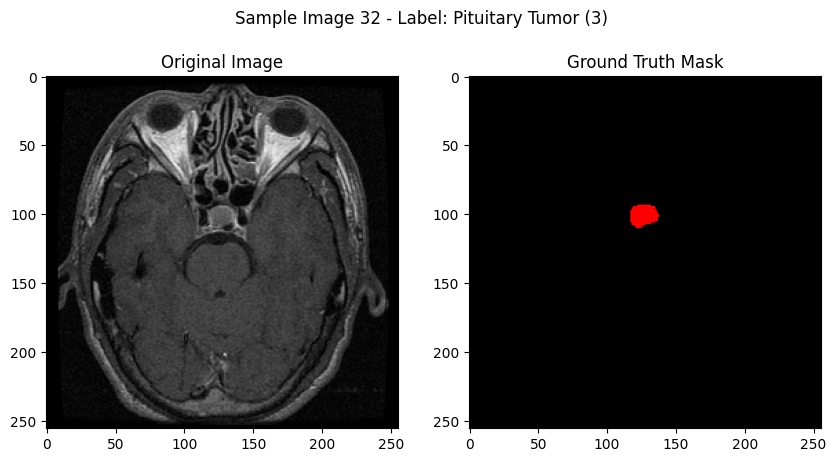

Label 1 (Type): 78 slices, 78.79% of the dataset
Label 3 (Type): 14 slices, 14.14% of the dataset
Label 2 (Type): 7 slices, 7.07% of the dataset
Data type of image: float32
Data type of masks: float32


In [18]:
def load_and_preprocess_data(data_dir, image_dimension=256):
    images = []
    masks = []
    labels = []  # Store labels to check distribution
    files = os.listdir(data_dir)

    # Data integrity check
    print(f"Total files found: {len(files)}")
    processed_count = 0

    for i, file in enumerate(files, start=1):
        try:
            mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0] # Load the .mat file
            
            # Resize and normalize the images
            image = mat_file['image']
            image = cv2.resize(image, dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_CUBIC)
            image = image.astype(np.float32) / 255.0  # Scale image to range [0, 1]
            image = np.expand_dims(image, axis=-1)  # Add the channel dimension (fprep or check later)

            # Resize and prepare mask for multi-class segmentation
            mask = mat_file['tumorMask'].astype('uint8')
            mask = cv2.resize(mask, dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask, axis=-1)  # Add the channel dimension (prep for check later)

            # Get the label and convert to one-hot
            label = int(mat_file['label'])  # assuming label is directly accessible
            one_hot_mask = np.zeros((image_dimension, image_dimension, 3), dtype=np.float32)  # three classes # set dtype to float32
            for j in range(1, 4):  # labels are 1, 2, 3
                one_hot_mask[:, :, j-1] = (mask[:, :, 0] == j).astype(np.float32)  # Cast to float32

            # Append processed image and mask to their respective lists
            images.append(image)
            masks.append(one_hot_mask)
            #masks.append(mask)
            labels.append(label)
            processed_count += 1

            if i % 10 == 0:
                sys.stdout.write(f'\r[{i}/{len(files)}] images loaded: {i / float(len(files)) * 100:.1f} %')
                sys.stdout.flush()

        except Exception as e:
            print(f"Failed to process file {file}: {e}")
            
    print(f"\nFinished loading and processing data. Successfully processed {processed_count}/{len(files)} files.")
    return np.array(images), np.array(masks), np.array(labels)

def visualize_sample_images(images, masks, labels, num_samples=5):
    """Visual inspection of images and masks, with labels indicating tumor type."""
    # Mapping of label numbers to tumor names
    label_to_tumor = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
    
    indices = np.random.choice(len(images), num_samples, replace=False)
    for i in indices:
        # Get tumor type from label
        tumor_type = label_to_tumor.get(labels[i], "Unknown Tumor Type")
        title = f"Sample Image {i+1} - Label: {tumor_type} ({labels[i]})"
        show_image_and_mask(images[i], masks[i], title)

def check_data_distribution(labels):
    """Check for class distribution across different tumor types."""
    from collections import Counter
    label_counts = Counter(labels)
    total_counts = len(labels)
    for label, count in label_counts.items():
        print(f"Label {label} (Type): {count} slices, {count / total_counts * 100:.2f}% of the dataset")

def show_image_and_mask(image, mask, title):
    """Displays an image and its corresponding mask side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(mask, cmap='viridis')
    ax[1].set_title('Ground Truth Mask')
    plt.suptitle(title)
    plt.show()

data_dir = '/Users/elizabethnemeti/Desktop/data' # local runs
# data_dir = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/data' # cluster runs
image_dimension = 256

# Func to load and preprocess the data
images, masks, labels = load_and_preprocess_data(data_dir, image_dimension)

# Visualization for sample images and masks
visualize_sample_images(images, masks, labels, num_samples=1) # best is 3

# Check data distribution for class imbalance
check_data_distribution(labels)

# Check data types of masks and predictions to make sure they're both float32
print(f"Data type of image: {images.dtype}")
print(f"Data type of masks: {masks.dtype}")

# Local Save (optional)
save_path = '/Users/elizabethnemeti/Desktop/UNET_preprocessed_files' # local runs
# save_path = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/UNET_preprocessed_files' # cluster runs

np.save(os.path.join(save_path, 'images.npy'), images)
np.save(os.path.join(save_path, 'masks.npy'), masks)
np.save(os.path.join(save_path, 'labels.npy'), labels)

Splitting the dataset into Training, Validation and Test Set

- Split Training, Validation and Testing data
- 80% (60:20) training + validation -> data for learning and to tune the model's hyperparameters without overfitting
- 20% testing -> to evaluate model's performance on unseen data
- Using Single validation split strategy for less computation time/resources
- use 5-fold cross validation if computational resources allow

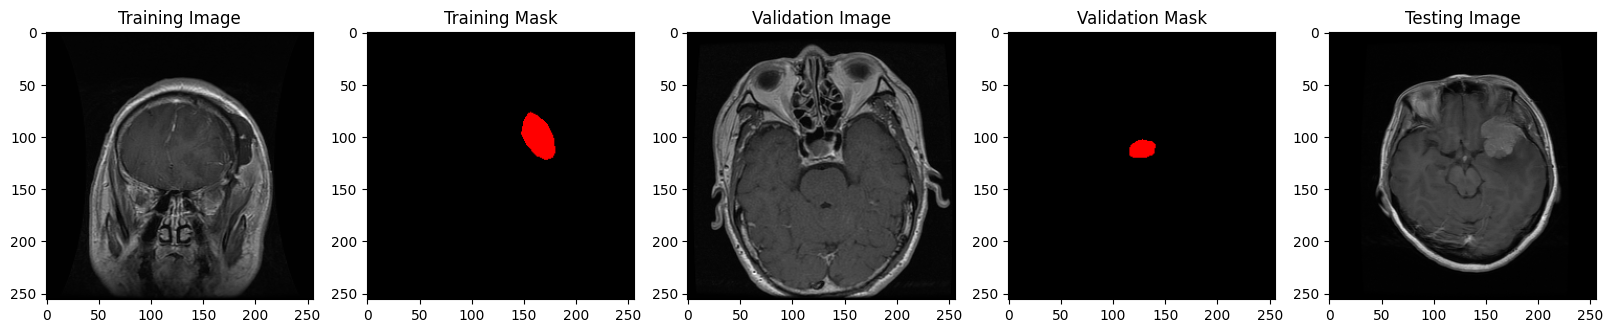

Total Label Distribution: {1: 78, 2: 7, 3: 14}
Training Label Distribution: {1: 46, 2: 5, 3: 8}
Validation Label Distribution: {1: 16, 2: 1, 3: 3}
Testing Label Distribution: {1: 16, 2: 1, 3: 3}
Data type of images_train: float32
Data type of masks_train: float32
Data type of labels_train: int64
Data type of images_val: float32
Data type of masks_val: float32
Data type of labels_val: int64
Data type of images_test: float32
Data type of masks_test: float32
Data type of labels_test: int64
Training Images shape: (59, 256, 256, 1)
Training Masks shape: (59, 256, 256, 3)
Validation Images shape: (20, 256, 256, 1)
Validation Masks shape: (20, 256, 256, 3)
Testing Images shape: (20, 256, 256, 1)
Testing Masks shape: (20, 256, 256, 3)


In [19]:
def split_data(images, masks, labels, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split data into training, validation, and testing sets.
    - test_size specifies the proportion of the data for testing.
    - val_size specifies the proportion of the training data for validation.
    """
    images_train, images_test, masks_train, masks_test, labels_train, labels_test = train_test_split(
        images, masks, labels, test_size=test_size, random_state=random_state, stratify=labels)
    
    images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
        images_train, masks_train, labels_train, test_size=val_size, random_state=random_state, stratify=labels_train)

    return images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test

def check_distribution(labels, title="Label distribution"):
    """Print the distribution of labels."""
    unique, counts = np.unique(labels, return_counts=True)
    label_dict = dict(zip(unique, counts))
    print(f"{title}: {label_dict}")
    

def visualize_data_samples(images_train, masks_train, images_val, masks_val, images_test):
    """Display the first image and mask from training, validation, and testing sets."""
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes[0].imshow(images_train[0], cmap='gray')
    axes[0].set_title('Training Image')
    axes[1].imshow(masks_train[0], cmap='viridis')
    axes[1].set_title('Training Mask')
    axes[2].imshow(images_val[0], cmap='gray')
    axes[2].set_title('Validation Image')
    axes[3].imshow(masks_val[0], cmap='viridis')
    axes[3].set_title('Validation Mask')
    axes[4].imshow(images_test[0], cmap='gray')
    axes[4].set_title('Testing Image')
    plt.show()

# Split the data into training, validation, and testing sets
images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test = split_data(images, masks, labels, test_size=0.2, val_size=0.25)

# Visualization for the first training, validation, and testing images
visualize_data_samples(images_train, masks_train, images_val, masks_val, images_test)  # You might want to adjust this to include validation images.

# Check label distributions
check_distribution(labels, "Total Label Distribution")
check_distribution(labels_train, "Training Label Distribution")
check_distribution(labels_val, "Validation Label Distribution")
check_distribution(labels_test, "Testing Label Distribution")

# DEBUG: Check data types to make sure images and masks are float32, all labels can be int64
print(f"Data type of images_train: {images_train.dtype}")
print(f"Data type of masks_train: {masks_train.dtype}")
print(f"Data type of labels_train: {labels_train.dtype}")
print(f"Data type of images_val: {images_val.dtype}")
print(f"Data type of masks_val: {masks_val.dtype}")
print(f"Data type of labels_val: {labels_val.dtype}")
print(f"Data type of images_test: {images_test.dtype}")
print(f"Data type of masks_test: {masks_test.dtype}")
print(f"Data type of labels_test: {labels_test.dtype}")

print(f"Training Images shape: {images_train.shape}")
print(f"Training Masks shape: {masks_train.shape}")

print(f"Validation Images shape: {images_val.shape}")
print(f"Validation Masks shape: {masks_val.shape}")

print(f"Testing Images shape: {images_test.shape}")
print(f"Testing Masks shape: {masks_test.shape}")

Check Dimensions Before Training (optional, recommended)

- MRI scans are generally single-channel (grayscale), where each pixel represents an intensity value.
- Lack of an explicit channel dimension in the arrays ((512, 512) instead of (512, 512, 1)) is common because the single channel is implicit in grayscale images.
- However, for processing in DL models like U-Net, we need to explicitly include the channel dimension.

- FOR IMAGES: typically single-channel for grayscale -> correct shape is (512, 512, 1) for DL processing
- FOR MASKS: for multi-class segmentation, especially when one-hot encoded with three classes (Meningioma, Glioma, Pituitary Tumor), should have shape (512, 512, 3) where each channel corresponds to one class

In [20]:
def check_dimensions(images, masks, required_image_shape, required_mask_shape):
    assert images[0].shape == required_image_shape, f"Image shape mismatch: expected {required_image_shape}, got {images[0].shape}"
    assert masks[0].shape == required_mask_shape, f"Mask shape mismatch: expected {required_mask_shape}, got {masks[0].shape}"
    print(f"Image shape is {images[0].shape} and mask shape is {masks[0].shape}.")
    print("All images and masks correctly match the required shapes.")

# Required shape for U-Net
required_image_shape = (256, 256, 1)  # This is for images, which are grayscale and should have a single channel explicitly.
required_mask_shape = (256, 256, 3)   # This is for masks, which are one-hot encoded across three classes.

data_sets = {
    'training': (images_train, masks_train),
    'validation': (images_val, masks_val),
    'testing': (images_test, masks_test)
}

check_dimensions(images, masks, required_image_shape, required_mask_shape)

Image shape is (256, 256, 1) and mask shape is (256, 256, 3).
All images and masks correctly match the required shapes.


Define Metrics

Dice coef -> calculates the overlap between the predicted and true masks in segmentation
Dice loss -> minimize difference between the predicted and true masks
Jaccard coeff -> measures similarity/diversity between predicted and true masks (0-1 val again)
Jaccard loss -> minimize loss

- For loss functions like BCE loss, Jaccard loss, and Focal loss, you want to monitor the loss itself ('BCE_loss', 'Jaccard_loss', or 'Focal_loss') because you want to minimize it
- For coefficients -> you're looking to maximize you would monitor 'Dice_coef' or 'Jaccard_coef'
- potentially adjust the weighting/scales between categorical crossentropy and Dice loss to improve performance

In [21]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, 'float32'))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, 'float32'))
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# iou's loss
def jaccard_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    jac = (intersection + smooth) / (union + smooth)
    return 1 - jac

# will be UNET architecture's loss function
# so model learns to classify each pixel correctly but also maximizes the overlap between the predicted and actual segments
#def combined_loss(y_true, y_pred):
#    return categorical_crossentropy(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)) + dice_loss(y_true, y_pred)

# trying out weighting to improve penalty
def combined_loss(y_true, y_pred, weight_ce=0.1, weight_dice=0.9):
    ce_loss = categorical_crossentropy(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32))
    d_loss = dice_loss(y_true, y_pred)
    return weight_ce * ce_loss + weight_dice * d_loss  # cahnge weighting here

# custom specificity funcs for multi-class segmentation 

# function calculates the specificity for a single class
def class_specificity(y_true, y_pred, class_id):
    y_true_class = tf.cast(tf.equal(y_true, class_id), tf.float32)
    y_pred_class = tf.cast(tf.equal(y_pred, class_id), tf.float32)
    true_negatives = tf.reduce_sum((1 - y_true_class) * (1 - y_pred_class))
    possible_negatives = tf.reduce_sum(1 - y_true_class)
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# wrapper that calls class_specificity for each class in the multi-class problem and then averages their specificities
# necessary to measure specificity for each class individually and then find the average specificity across all classes
def multi_class_specificity(num_classes):
    # nested function that allows for the creation of a custom Keras metric that can be used during the compilation of the model
    def specificity(y_true, y_pred):
        specificities = [class_specificity(y_true, y_pred, i) for i in range(num_classes)]
        return tf.reduce_mean(tf.stack(specificities), axis=0)
    specificity.__name__ = 'multi_class_specificity'
    return specificity

# even if recompiling the model, names/keys will remain consistent because of explicit setting here
recall = Recall(name='my_recall')
precision = Precision(name='my_precision')

2024-05-09 12:38:18.701380: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-09 12:38:18.701410: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-09 12:38:18.701419: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-09 12:38:18.701641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-09 12:38:18.701668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


UNET Model Architecture

- defined the model's structure, how it should compile, including what optimizer, loss function, and metrics to use
- make suire images are scaled to [0, 1] to fit ReLU activation in the network
- Dropout prevents overfitting by randomly setting a fraction of input units to 0 at each update during training time
- Batch Normalization helps in accelerating the training process by normalizing the inputs of activation functions

Slow training?
- potentially change image sizd from 512 -> 256 for lower resolution but quicker training
- change learning rate
- fewer epochs/batches
- connect better GPU/more GPUs
- monitor fewer metrics

In [22]:
def unet(weights=None, input_size=(256, 256, 1)):
    inp = tf.keras.Input(input_size)
    
    # Encoder
    # Block 1: Two convolutional layers followed by pooling to downsample the feature maps
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    
    # Block 2
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    p2 = Dropout(0.3)(p2)
    
    # Block 3
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    
    # Block 4
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Block 5: Bottleneck part, no pooling
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    
    # Decoder
    # Block 6: Upsample and concatenate with the corresponding encoder layer (c4), followed by convolutions
    u6 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    concat6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    
    # Block 7
    u7 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    concat7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    
    # Block 8
    u8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    concat8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.3)(c8)
    
    # Block 9: Final upsampling and concatenation with the first encoder layer
    u9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    concat9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    # Output Layer
    outputs = Conv2D(3, (1, 1), activation='softmax')(c9)  # 3 classes for the 3 tumor types
    
    # Final model assembly
    model = Model(inputs=[inp], outputs=[outputs])

    # Compile the model with chosen optimizer, loss function, and metrics
    model.compile(
    optimizer=Adam(), 
    loss=combined_loss,  
    metrics=[
        dice_loss, 
        'categorical_crossentropy',  
        multi_class_specificity(3),  # Custom specificity metric for 3 classes
        'accuracy',  
        recall, 
        precision  
    ]
)
    
    return model

In [23]:
# set training parameters early 
num_samples = len(images_train)
epochs = 5
batch_size = 4
steps_per_epoch = num_samples // batch_size
seed = 30

Data Augmentation Stage

- implemented next with model training (do NOT use on validation or testing data)
- doesn't actually create additional 'physical' images that are stores, makes 'virtual' variations real-time only used during that training
- data augmentation = randomly transforming images via shifts, flips, rotations, zooms for better generalizability performance
- do NOT merge the generators, they must stay separate to retain correct channel number = 1
- using ImageDataGenerator from Keras (note: just specifies/defines HOW to perform augmentations - doesn't generate data by itself)
- can adjust parameters as needed, but avoid aggressive transformations to refrain from introducing artifacts
- MUST select matching seeds to prevent misalignment between an augmented image and its corresponding augmented image
- quality of augmentions can be altered/improved by changing parameter 'fill_mode' that can be set to either:
      - default 'nearest' (replicates nearest pixel value)
      - 'constant' (pixels filled with a constant value, where 0 is black)
      - 'reflect' (pixels filled in mirrored fashion of the image border) 
      - 'wrap' (pixels filled from opposite image border than reflect does)

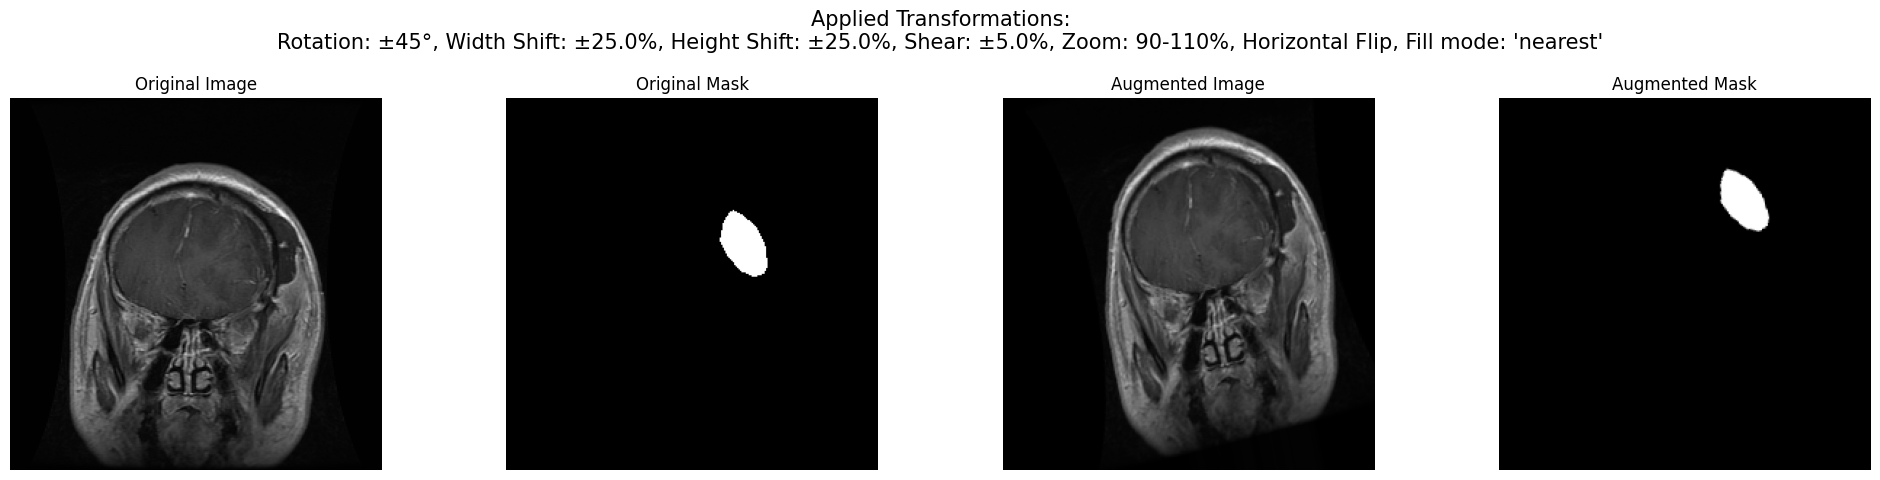

Checking first batch output:
Augmented image batch shape is correct: (4, 256, 256, 1)
Augmented mask batch shape is correct: (4, 256, 256, 3)


In [24]:
# Data Augmentation (optional, recommended)

is_augmented = True # activate augmentation Y/N?

# func to indicate whether or not augmentation (and its params) should be applied via boolean 'augment'
def get_augmentation_params(is_augmented):
    if is_augmented:                    # will augment
        return {
            'rotation_range': 45,       # rotate left-right by x degrees (0-360 degrees max, 0-90 typical)
            'width_shift_range': 0.25,  # shift horizontally ( 10% shift up of total img width) -> simulates subject off center
            'height_shift_range': 0.25, # shift vertically ( 10% shift up of total img height) -> simulates subject off center
            'shear_range': 0.05,        # change angle of looking at target (0-25 degrees)
            'zoom_range': [0.9, 1.1],   # add zoom to image -> simulates viewing target from closer/farther away; 0.9 = 90% original image shown so very zoomed out to 110% of image shown so zoomed in
            'horizontal_flip': True,    # yes/no flipped horizontally -> effective for images not greatly affected by flipped orientation e.g. landscape vs number
            'fill_mode': 'nearest'      # directs how to fill new pixels following a rotations/shift transformation
        }
    else:
        return {'fill_mode': 'nearest'} # won't augment

# create one generator for both images and masks to keep everythign synched
def create_augmentation_generator(images, masks, batch_size, seed, apply_augmentation=True):
    if apply_augmentation:
        augmentation_params = get_augmentation_params(True)
    else:
        augmentation_params = {'fill_mode': 'nearest'}  # Minimal transformation

    augmentor = ImageDataGenerator(**augmentation_params)

    combined = np.concatenate((images, masks), axis=-1) # concatenate images and masks - keep synched for this step
    generator = augmentor.flow(
        combined,
        batch_size=batch_size,
        seed=seed,
        shuffle=False # keep shuffling off to maintain original img for comparison with augmented img
    )

    while True:
        combined_batch = next(generator)
        images_batch = combined_batch[..., :images.shape[-1]]
        masks_batch = combined_batch[..., images.shape[-1]:]
        yield (images_batch, masks_batch)

original_generator = create_augmentation_generator(images_train, masks_train, batch_size, seed, apply_augmentation=False)
augmented_generator = create_augmentation_generator(images_train, masks_train, batch_size, seed, apply_augmentation=True)

# for development ONLY -> use visualizations to verify augmentation went smoothly/images are acceptable

def compare_original_and_augmented(original_gen, augmented_gen, num_samples=1):
    augmentation_params = get_augmentation_params(True)  # True because we need the full set for description
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

    # desription that's auto updated according to the parameters for on-sight interprtability
    # begin desc creation
    transformations = [
        f"Rotation: ±{augmentation_params['rotation_range']}°",
        f"Width Shift: ±{augmentation_params['width_shift_range']*100}%",
        f"Height Shift: ±{augmentation_params['height_shift_range']*100}%",
        f"Shear: ±{augmentation_params['shear_range']*100}%",
        f"Zoom: {int(augmentation_params['zoom_range'][0]*100)}-{int(augmentation_params['zoom_range'][1]*100)}%",
        "Horizontal Flip" if augmentation_params['horizontal_flip'] else "No Horizontal Flip",
        f"Fill mode: '{augmentation_params['fill_mode']}'"
    ]
    transformation_description = "Applied Transformations:\n" + ", ".join(transformations)
    fig.suptitle(transformation_description, fontsize=15) # added as header
    # end desc creation
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)  # debug check: keeps indexing intact, don't remove

    for i in range(num_samples):
        orig_images_batch, orig_masks_batch = next(original_gen)
        aug_images_batch, aug_masks_batch = next(augmented_gen)

        axes[i, 0].imshow(orig_images_batch[0, ..., 0], cmap='gray') # img 1 - original img
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(orig_masks_batch[0, ..., 0], cmap='gray') # img 2 - original mask
        axes[i, 1].set_title('Original Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(aug_images_batch[0, ..., 0], cmap='gray') # img 3 - augmented img
        axes[i, 2].set_title('Augmented Image')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(aug_masks_batch[0, ..., 0], cmap='gray') # img 4 - augmented mask
        axes[i, 3].set_title('Augmented Mask')
        axes[i, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # make space for header
    plt.show()

compare_original_and_augmented(original_generator, augmented_generator, num_samples=1) # call the plots -> do the images look acceptable?

# DEBUG CHECK: do our post data-augmentation model inputs match the required dimension and shape for training?
def check_augmented_data_shape(images_train, masks_train, batch_size, is_augmented):
    if is_augmented:
        print("Checking first batch output:")
        generator = create_augmentation_generator(images_train, masks_train, batch_size, seed, apply_augmentation=True)
        sample_img_output, sample_mask_output = next(generator)
        
        assert sample_img_output.shape == (batch_size, images_train.shape[1], images_train.shape[2], images_train.shape[3]), \
            f"Augmented image shape mismatch. Expected: (batch_size, height, width, channels), Got: {sample_img_output.shape}"
        assert sample_mask_output.shape == (batch_size, masks_train.shape[1], masks_train.shape[2], masks_train.shape[3]), \
            f"Augmented mask shape mismatch. Expected: (batch_size, height, width, channels), Got: {sample_mask_output.shape}"
        print(f"Augmented image batch shape is correct: {sample_img_output.shape}")
        print(f"Augmented mask batch shape is correct: {sample_mask_output.shape}")
    else:
        print(f"Images shape: {images_train.shape}")
        print(f"Masks shape: {masks_train.shape}")
        assert images_train.shape[0] == masks_train.shape[0], "Mismatch in number of images and masks."
        print("Non-augmented data shapes are correct.")

check_augmented_data_shape(images_train, masks_train, batch_size, is_augmented)

Model Training
- save the model with the best validation (development) accuracy until now
- a checkpoint saves the model's current state, including its weights, so we can resume training later/ use model from a particular epoch
- have different checks for different loss functions/metrics
- might need to use legacy version of Adam optimizer located at tf.keras.optimizers.legacy.Adam if too slow training times
- recommended: reinitialize model before each training run to avoid potential carryover weights/biases from prior trainings
- trainings are executed both WITH and WITHOUT data augmentation to compare best model fit

Memory Pressure Alleviations
- keep batch size under 4 if run locally to alleviate pressure
- include early stopping if validation loss isn't improving after a x number of epochs (set via 'patience')
- consider removing some metrics from architecutre + tracking

In [25]:
# Define visual checks for DURING training EPOCHS to compare actual vs predicted masks
# (optional, NOT recommended unless debugging and checking for overfitting)

class VisualizeSegmentation(Callback):
    def __init__(self, model, validation_data, num_samples=1):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        self.num_samples = num_samples 

    def on_epoch_end(self, epoch, logs=None):
        idxs = np.random.choice(len(self.validation_data[0]), self.num_samples, replace=False)
        images, masks = self.validation_data[0][idxs], self.validation_data[1][idxs]
        preds = self.model.predict(images)

        fig, axes = plt.subplots(self.num_samples, 2, figsize=(6, 3 * self.num_samples))  # can increae the figure size for better viewing

        for i, (mask, pred) in enumerate(zip(masks, preds)):
            if self.num_samples == 1:
                ax1, ax2 = axes
            else:
                ax1, ax2 = axes[i]

            ax1.imshow(mask[:,:,0], cmap='gray')
            ax1.set_title('True Mask')
            ax1.axis('off')
            
            ax2.imshow(pred[:,:,0], cmap='gray')
            ax2.set_title('Predicted Mask')
            ax2.axis('off') 

        plt.tight_layout()
        plt.show()

Epoch 1/5


2024-05-09 12:40:55.838392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.8864 - dice_loss: 0.9837 - categorical_crossentropy: 0.0111 - multi_class_specificity: 1.0000 - accuracy: 0.2736 - my_recall: 0.5842 - my_precision: 0.0172

2024-05-09 12:41:02.354857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 25.07287, saving model to best_model_no_aug.h5


/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 214ms/step


2024-05-09 12:41:03.597116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


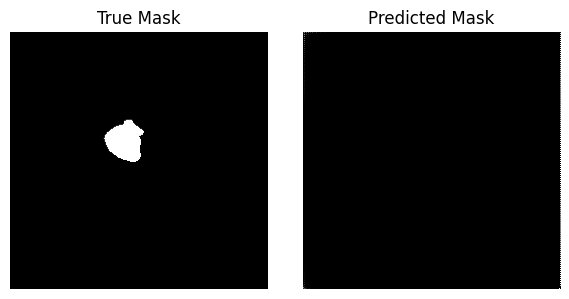

15/15 [==============================] - 9s 473ms/step - loss: 0.8864 - dice_loss: 0.9837 - categorical_crossentropy: 0.0111 - multi_class_specificity: 1.0000 - accuracy: 0.2736 - my_recall: 0.5842 - my_precision: 0.0172 - val_loss: 25.0729 - val_dice_loss: 1.0000 - val_categorical_crossentropy: 241.7288 - val_multi_class_specificity: 0.5565 - val_accuracy: 0.0020 - val_my_recall: 0.0000e+00 - val_my_precision: 0.0000e+00 - epoch: 1.0000
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 0.8831 - dice_loss: 0.9801 - categorical_crossentropy: 0.0072 - multi_class_specificity: 1.0000 - accuracy: 0.2258 - my_recall: 0.7002 - my_precision: 0.0836
Epoch 2: val_loss did not improve from 25.07287
1/1 [==============================] - 0s 16ms/step


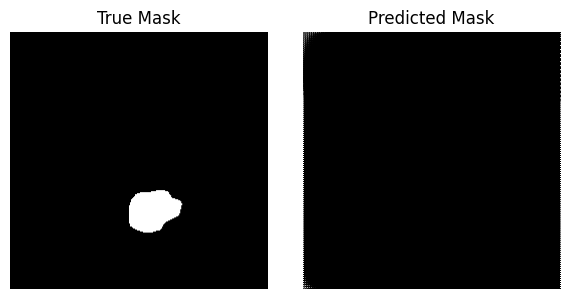

15/15 [==============================] - 6s 392ms/step - loss: 0.8831 - dice_loss: 0.9801 - categorical_crossentropy: 0.0072 - multi_class_specificity: 1.0000 - accuracy: 0.2258 - my_recall: 0.7002 - my_precision: 0.0836 - val_loss: 30.9215 - val_dice_loss: 1.0000 - val_categorical_crossentropy: 300.2152 - val_multi_class_specificity: 0.5615 - val_accuracy: 0.0035 - val_my_recall: 0.0000e+00 - val_my_precision: 0.0000e+00 - epoch: 2.0000
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 0.8841 - dice_loss: 0.9815 - categorical_crossentropy: 0.0081 - multi_class_specificity: 1.0000 - accuracy: 0.2514 - my_recall: 0.6014 - my_precision: 0.1073
Epoch 3: val_loss improved from 25.07287 to 6.39814, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 21ms/step


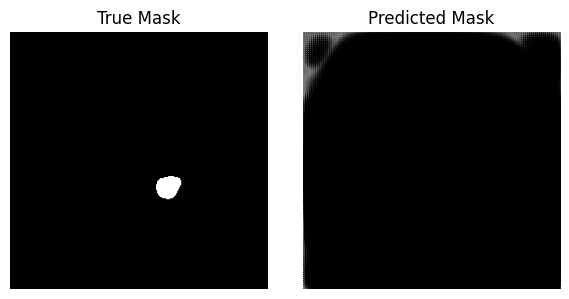

15/15 [==============================] - 6s 395ms/step - loss: 0.8841 - dice_loss: 0.9815 - categorical_crossentropy: 0.0081 - multi_class_specificity: 1.0000 - accuracy: 0.2514 - my_recall: 0.6014 - my_precision: 0.1073 - val_loss: 6.3981 - val_dice_loss: 1.0000 - val_categorical_crossentropy: 54.9814 - val_multi_class_specificity: 0.5806 - val_accuracy: 0.0011 - val_my_recall: 0.0000e+00 - val_my_precision: 0.0000e+00 - epoch: 3.0000
Epoch 4/5
15/15 [==============================] - ETA: 0s - loss: 0.8832 - dice_loss: 0.9803 - categorical_crossentropy: 0.0071 - multi_class_specificity: 1.0000 - accuracy: 0.2594 - my_recall: 0.6740 - my_precision: 0.0935
Epoch 4: val_loss improved from 6.39814 to 0.89303, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 14ms/step


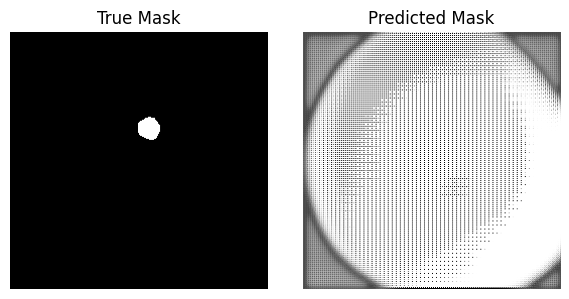

15/15 [==============================] - 6s 421ms/step - loss: 0.8832 - dice_loss: 0.9803 - categorical_crossentropy: 0.0071 - multi_class_specificity: 1.0000 - accuracy: 0.2594 - my_recall: 0.6740 - my_precision: 0.0935 - val_loss: 0.8930 - val_dice_loss: 0.9773 - val_categorical_crossentropy: 0.1345 - val_multi_class_specificity: 0.9146 - val_accuracy: 0.8547 - val_my_recall: 0.8218 - val_my_precision: 0.0136 - epoch: 4.0000
Epoch 5/5
15/15 [==============================] - ETA: 0s - loss: 0.8835 - dice_loss: 0.9810 - categorical_crossentropy: 0.0074 - multi_class_specificity: 1.0000 - accuracy: 0.2912 - my_recall: 0.6452 - my_precision: 0.0820
Epoch 5: val_loss improved from 0.89303 to 0.88064, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 31ms/step


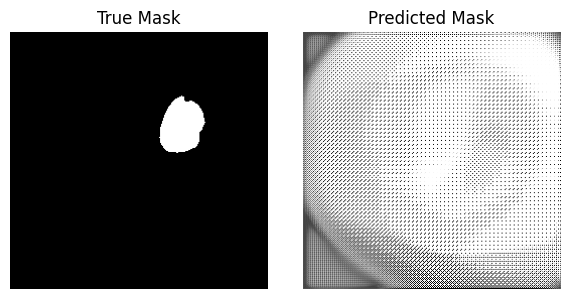

15/15 [==============================] - 6s 411ms/step - loss: 0.8835 - dice_loss: 0.9810 - categorical_crossentropy: 0.0074 - multi_class_specificity: 1.0000 - accuracy: 0.2912 - my_recall: 0.6452 - my_precision: 0.0820 - val_loss: 0.8806 - val_dice_loss: 0.9770 - val_categorical_crossentropy: 0.0137 - val_multi_class_specificity: 0.9525 - val_accuracy: 0.8268 - val_my_recall: 0.8483 - val_my_precision: 0.0142 - epoch: 5.0000
Training Metrics per Epoch:
    loss  dice_loss  categorical_crossentropy  multi_class_specificity  accuracy  my_recall  my_precision  val_loss  val_dice_loss  val_categorical_crossentropy  val_multi_class_specificity  val_accuracy  val_my_recall  val_my_precision  epoch
0.886422   0.983676                  0.011107                      1.0  0.273605   0.584222      0.017191 25.072872       0.999996                    241.728760                     0.556519      0.002014       0.000000          0.000000      1
0.883140   0.980148                  0.007183        

2024-05-09 12:41:28.611730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.8865 - dice_loss: 0.9837 - categorical_crossentropy: 0.0115 - multi_class_specificity: 1.0000 - accuracy: 0.2983 - my_recall: 0.6523 - my_precision: 0.0208

2024-05-09 12:41:34.653157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.04825, saving model to best_model_aug.h5


/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 204ms/step


2024-05-09 12:41:36.119753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


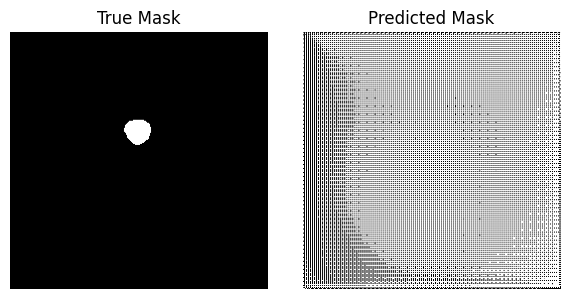

14/14 [==============================] - 8s 519ms/step - loss: 0.8865 - dice_loss: 0.9837 - categorical_crossentropy: 0.0115 - multi_class_specificity: 1.0000 - accuracy: 0.2983 - my_recall: 0.6523 - my_precision: 0.0208 - val_loss: 1.0482 - val_dice_loss: 0.9798 - val_categorical_crossentropy: 1.6641 - val_multi_class_specificity: 0.8318 - val_accuracy: 0.6990 - val_my_recall: 0.7426 - val_my_precision: 0.0104 - epoch: 1.0000
Epoch 2/5
14/14 [==============================] - ETA: 0s - loss: 0.8842 - dice_loss: 0.9815 - categorical_crossentropy: 0.0084 - multi_class_specificity: 1.0000 - accuracy: 0.2629 - my_recall: 0.6391 - my_precision: 0.0873
Epoch 2: val_loss did not improve from 1.04825
1/1 [==============================] - 0s 21ms/step


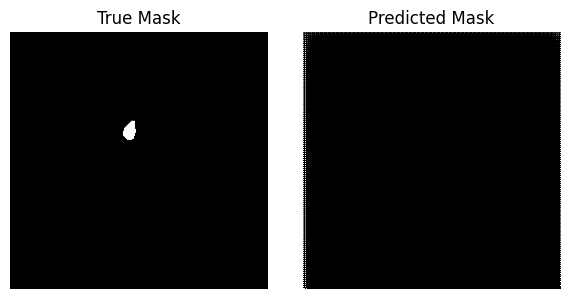

14/14 [==============================] - 6s 401ms/step - loss: 0.8842 - dice_loss: 0.9815 - categorical_crossentropy: 0.0084 - multi_class_specificity: 1.0000 - accuracy: 0.2629 - my_recall: 0.6391 - my_precision: 0.0873 - val_loss: 1.9823 - val_dice_loss: 1.0000 - val_categorical_crossentropy: 10.8229 - val_multi_class_specificity: 0.5912 - val_accuracy: 0.0060 - val_my_recall: 0.0000e+00 - val_my_precision: 0.0000e+00 - epoch: 2.0000
Epoch 3/5
14/14 [==============================] - ETA: 0s - loss: 0.8837 - dice_loss: 0.9809 - categorical_crossentropy: 0.0086 - multi_class_specificity: 1.0000 - accuracy: 0.2480 - my_recall: 0.6083 - my_precision: 0.1013
Epoch 3: val_loss did not improve from 1.04825
1/1 [==============================] - 0s 12ms/step


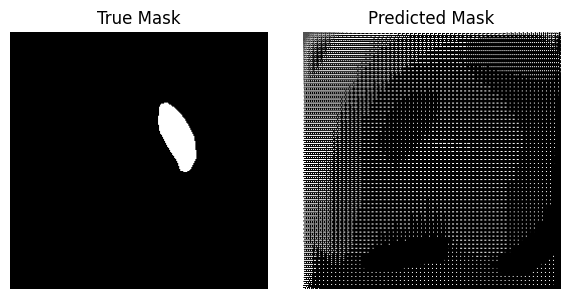

14/14 [==============================] - 5s 380ms/step - loss: 0.8837 - dice_loss: 0.9809 - categorical_crossentropy: 0.0086 - multi_class_specificity: 1.0000 - accuracy: 0.2480 - my_recall: 0.6083 - my_precision: 0.1013 - val_loss: 2.1021 - val_dice_loss: 0.9967 - val_categorical_crossentropy: 12.0507 - val_multi_class_specificity: 0.6260 - val_accuracy: 0.1388 - val_my_recall: 0.1201 - val_my_precision: 0.0017 - epoch: 3.0000
Epoch 4/5
14/14 [==============================] - ETA: 0s - loss: 0.8823 - dice_loss: 0.9796 - categorical_crossentropy: 0.0065 - multi_class_specificity: 1.0000 - accuracy: 0.2866 - my_recall: 0.6466 - my_precision: 0.1075
Epoch 4: val_loss improved from 1.04825 to 0.87556, saving model to best_model_aug.h5
1/1 [==============================] - 0s 36ms/step


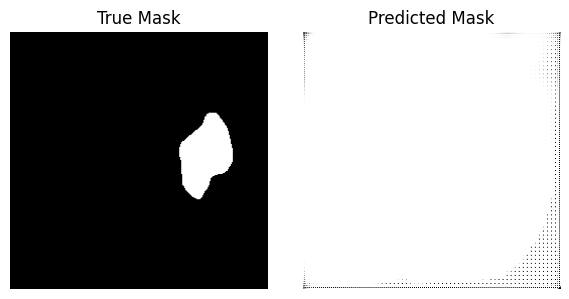

14/14 [==============================] - 6s 406ms/step - loss: 0.8823 - dice_loss: 0.9796 - categorical_crossentropy: 0.0065 - multi_class_specificity: 1.0000 - accuracy: 0.2866 - my_recall: 0.6466 - my_precision: 0.1075 - val_loss: 0.8756 - val_dice_loss: 0.9728 - val_categorical_crossentropy: 1.1187e-11 - val_multi_class_specificity: 0.8968 - val_accuracy: 0.9922 - val_my_recall: 1.0000 - val_my_precision: 0.0138 - epoch: 4.0000
Epoch 5/5
14/14 [==============================] - ETA: 0s - loss: 0.8844 - dice_loss: 0.9818 - categorical_crossentropy: 0.0076 - multi_class_specificity: 1.0000 - accuracy: 0.3025 - my_recall: 0.5954 - my_precision: 0.1010
Epoch 5: val_loss did not improve from 0.87556
1/1 [==============================] - 0s 20ms/step


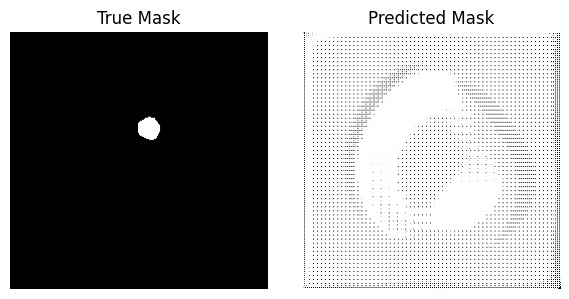

14/14 [==============================] - 5s 375ms/step - loss: 0.8844 - dice_loss: 0.9818 - categorical_crossentropy: 0.0076 - multi_class_specificity: 1.0000 - accuracy: 0.3025 - my_recall: 0.5954 - my_precision: 0.1010 - val_loss: 0.8790 - val_dice_loss: 0.9736 - val_categorical_crossentropy: 0.0275 - val_multi_class_specificity: 0.8970 - val_accuracy: 0.9379 - val_my_recall: 0.9712 - val_my_precision: 0.0134 - epoch: 5.0000
Training Metrics per Epoch:
    loss  dice_loss  categorical_crossentropy  multi_class_specificity  accuracy  my_recall  my_precision  val_loss  val_dice_loss  val_categorical_crossentropy  val_multi_class_specificity  val_accuracy  val_my_recall  val_my_precision  epoch
0.886501   0.983724                  0.011502                 0.999999  0.298261   0.652320      0.020810  1.048248       0.979823                  1.664065e+00                     0.831758      0.698968       0.742586          0.010391      1
0.884170   0.981477                  0.008403        

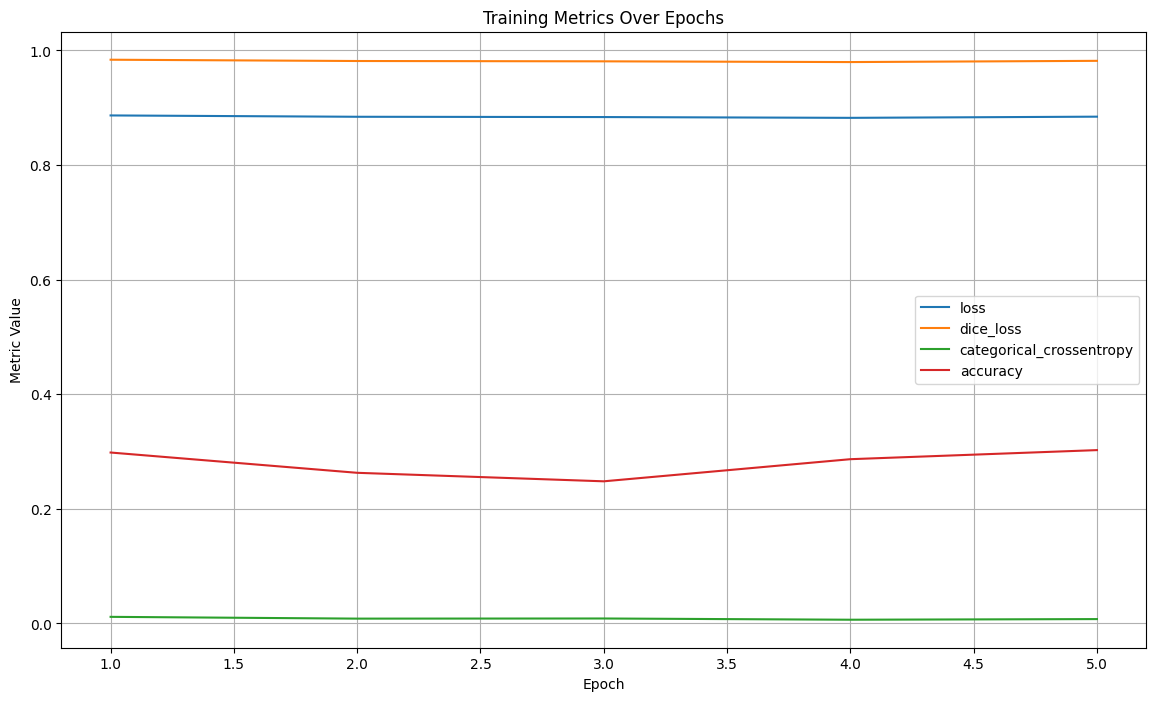

In [27]:
# Training Stage

# initialize both model instances
model_with_aug = unet()  
model_without_aug = unet() 

# defining checkpoints and patience 
checkpoint_aug = ModelCheckpoint('best_model_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_no_aug = ModelCheckpoint('best_model_no_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# calling viz func
vis_callback_with_aug = VisualizeSegmentation(model_with_aug, (images_val, masks_val), num_samples=1)
vis_callback_without_aug = VisualizeSegmentation(model_without_aug, (images_val, masks_val), num_samples=1)

# easier tracking of metrics via table
class MetricsCollector(Callback):
    def on_train_begin(self, logs=None):
        self.metrics_history = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epoch'] = epoch + 1  # make it legible & track epochs
        self.metrics_history.append(logs)

    def on_train_end(self, logs=None):
        metrics_df = pd.DataFrame(self.metrics_history)
        # columns_order = ['epoch', 'loss', 'dice_loss', 'categorical_crossentropy', ...] # reorder df for specific columns
        # metrics_df = metrics_df[columns_order]
        print("Training Metrics per Epoch:")
        print(metrics_df.to_string(index=False)) 

metrics_collector = MetricsCollector()

# training WITHOUT data augmentation
history_without_aug = model_without_aug.fit(
    x=images_train, 
    y=masks_train,
    validation_data=(images_val, masks_val),
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=[checkpoint_no_aug, early_stopping, vis_callback_without_aug, metrics_collector]
)

# training WITH data augmentation
history_with_aug = model_with_aug.fit(
    augmented_generator,
    steps_per_epoch=len(images_train) // batch_size,
    validation_data=(images_val, masks_val),
    epochs=epochs,
    callbacks=[checkpoint_aug, early_stopping, vis_callback_with_aug, metrics_collector]
)

def plot_metrics(metrics_df):
    plt.figure(figsize=(14, 8))
    for metric in ['loss', 'dice_loss', 'categorical_crossentropy', 'accuracy']: 
        if metric in metrics_df.columns:
            plt.plot(metrics_df['epoch'], metrics_df[metric], label=metric)
    plt.title('Training Metrics Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_metrics(pd.DataFrame(metrics_collector.metrics_history)) # show tracked metrics

In [ ]:
beep()

In [ ]:
# Visualization: comparing validation error and training error between augmented model and non-augmented model

epochs_range = range(epochs)
plt.figure(figsize=(8, 6))

#  model without data augmentation
plt.plot(epochs_range, history_without_aug.history['loss'], label='Training Loss Without Augmentation', color='lightblue', linestyle='--', linewidth=2)
plt.plot(epochs_range, history_without_aug.history['val_loss'], label='Validation Loss Without Augmentation', color='orange', linestyle='--', linewidth=2)

# model with data augmentation
plt.plot(epochs_range, history_with_aug.history['loss'], label='Training Loss With Augmentation', color='lightblue', linestyle='-', linewidth=2.5)
plt.plot(epochs_range, history_with_aug.history['val_loss'], label='Validation Loss With Augmentation', color='orange', linestyle='-', linewidth=2.5)

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model Testing
- test model with the test set to see how well it performs on unseen data
- we want our coefficent high and our loss low
- the data augmented model should perform better on testing

Underfitting: both training and validation loss are high -> not learning effectively
Overfitting: training loss continues to decrease while validation loss begins to increase -> not generalizing well to validation data
Good fit: both losses decrease to a point of stability with a minimal gap between the two final loss values

In [ ]:
Keep Cell Active to Break Off Pipeline Before Seeing Test Data

In [ ]:
# Test Model

# retrieve best model from training
# dont need to add standard metrics Recall, Precision, Accuracy just custom ones
best_model = load_model('best_model.h5', custom_objects={
    'combined_loss': combined_loss,
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'multi_class_specificity': multi_class_specificity(3)
})

test_loss, test_dice, test_iou, test_acc, test_recall, test_precision, test_specificity = best_model.evaluate(images_test, masks_test)
print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice}")
print(f"Test IoU Coefficient: {test_iou}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test Specificity: {test_specificity}")

# Save the final model after training
model.save('final_trained_model.h5')

Visualize Final Segmentation Results (Predicted Masks)

- visualize jsut a subset of the segmentation results below
- save all segmentation result plots to a folder

In [ ]:
plot_save_path = '/Users/elizabethnemeti/Desktop/UNET_segmented_masks'  # local runs
# plot_save_path = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/UNET_segmented_masks'  # cluster runs

if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# Visualize a few random test images below
num_random_samples = 3
idxs = np.random.choice(len(images_test), num_random_samples, replace=False)

# Generate predictions for selected samples
selected_preds = best_model.predict(images_test[idxs])

# Visualize the predictions along with images and true masks
for i, idx in enumerate(idxs):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(images_test[idx].squeeze(), cmap='gray')
    axs[0].set_title('Test Image')
    axs[1].imshow(masks_test[idx].squeeze(), cmap='gray')
    axs[1].set_title('True Mask')
    axs[2].imshow(selected_preds[i].squeeze(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Generate predictions for all samples and save the plots to the folder
for idx in range(len(images_test)):
    # Predict the mask for the current test image
    pred = best_model.predict(images_test[idx:idx+1])[0].squeeze()

    # Create figure without actually displaying it
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    axs[0].imshow(images_test[idx].squeeze(), cmap='gray')
    axs[0].set_title('Test Image')
    axs[1].imshow(masks_test[idx].squeeze(), cmap='gray')
    axs[1].set_title('True Mask')
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')

    fig.savefig(os.path.join(plot_save_path, f'visualization_{idx}.png'))
    plt.close(fig) 

print(f"Saved {len(images_test)} visualization plots to: {plot_save_path}")

Performance Plots for Loss & Metrics

- one plot per average score for each metric
- 28 plots (7x4) where
    - 7 metrics =  Dice Coef, IoU Coef, Accuracy, Recall, Precision, Specificity, Loss
    - 4 variables = classes average, tumor class 1, tumor class 2, tumor class 3

Reminder: labels 1, 2, and 3 correspond to meningioma, glioma, and pituitary tumor respectively

In [ ]:
# Performance Plots for Loss & Metrics

history_dict = history.history
print(history.history.keys()) # make sure keys match/ explicity set bef
print(history_dict)

epochs = range(1, len(history_dict['loss']) + 1) # sets x-axis to epochs correctly

# Set up the matplotlib figure and axes, organized in a 2x3 layout
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Dice Coefficient
axs[0, 0].plot(epochs, history_dict['dice_coef'], label='Train Dice Coef')
axs[0, 0].plot(epochs, history_dict['val_dice_coef'], label='Val Dice Coef')
axs[0, 0].set_title('Dice Coefficient')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Dice Coef')
axs[0, 0].legend()

# IoU
axs[0, 1].plot(epochs, history_dict['iou_coef'], label='Train IoU')
axs[0, 1].plot(epochs, history_dict['val_iou_coef'], label='Val IoU')
axs[0, 1].set_title('IoU Coefficient')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('IoU')
axs[0, 1].legend()

# Accuracy
axs[0, 2].plot(epochs, history_dict['accuracy'], label='Train Accuracy')
axs[0, 2].plot(epochs, history_dict['val_accuracy'], label='Val Accuracy')
axs[0, 2].set_title('Accuracy')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Accuracy')
axs[0, 2].legend()

# Recall/Sensitivity
axs[1, 0].plot(epochs, history_dict['my_recall'], label='Train Recall')  
axs[1, 0].plot(epochs, history_dict['val_my_recall'], label='Val Recall')  
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Precision
axs[1, 1].plot(epochs, history_dict['my_precision'], label='Train Precision')  
axs[1, 1].plot(epochs, history_dict['val_my_precision'], label='Val Precision') 
axs[1, 1].set_title('Precision')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].legend()

# Specificity
axs[1, 2].plot(epochs, history_dict['multi_class_specificity'], label='Train Specificity')  
axs[1, 2].plot(epochs, history_dict['val_multi_class_specificity'], label='Val Specificity')  
axs[1, 2].set_title('Specificity')
axs[1, 2].set_xlabel('Epochs')
axs[1, 2].set_ylabel('Specificity')
axs[1, 2].legend()

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

# Separate plot for Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, history_dict['loss'], label='Train Loss')
plt.plot(epochs, history_dict['val_loss'], label='Val Loss')
plt.title('Model Combined Loss')
plt.xlabel('Epochs')
plt.ylabel('Combined Loss')
plt.legend()
plt.show()

Benchmarking Stage

- load the pretrained models

In [33]:
# data loading
benchmark_data_dir = '/Users/elizabethnemeti/Desktop/benchmark_data_brats'
if not os.path.isdir(benchmark_data_dir):
    raise FileNotFoundError(f"No such directory: {benchmark_data_dir}")

file_count = 0
for filename in os.listdir(benchmark_data_dir):
    if filename.endswith('.mat'):
        file_count += 1
        print(filename)
print(f"Total .mat files found: {file_count}")

# reapply preprocessing
image_dimension = 256
images, masks, labels = load_and_preprocess_data(benchmark_data_dir, image_dimension)
visualize_sample_images(images, masks, labels, num_samples=1)
check_data_distribution(labels)  # Just informative
print(f"Data type of image: {images.dtype}")
print(f"Data type of masks: {masks.dtype}")

# load pretrained models from Training Stage
pretrained_no_aug_model = load_model('best_model_no_aug.h5')
pretrained_aug_model = load_model('best_model_aug.h5')

# test on benchmark dataset
predictions_no_aug = pretrained_no_aug_model.predict(images)
predictions_aug = pretrained_aug_model.predict(images)

# assuming 'evaluate_model' is a function you have to evaluate the model using the actual masks
results_no_aug = evaluate_model(masks, predictions_no_aug)
results_aug = evaluate_model(masks, predictions_aug)

# how do our models fair on benchmarked data with and without data augmentation? 
def plot_comparison(results_no_aug, results_aug):
    metrics = list(results_no_aug.keys())
    bar_width = 0.35
    index = np.arange(len(metrics))
    fig, ax = plt.subplots()
    bar1 = ax.bar(index, list(results_no_aug.values()), bar_width, label='Without Augmentation')
    bar2 = ax.bar(index + bar_width, list(results_aug.values()), bar_width, label='With Augmentation')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Values')
    ax.set_title('Model Performance Comparison on Benchmark Data')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics)
    ax.legend()
    plt.show()

plot_comparison(results_no_aug, results_aug, 'Benchmark Performance Comparison With and Without Augmentation')

# how do our models fair on benchmarked data vs original data? 

Brats18_2013_8_1_t1.mat
Brats18_2013_9_1_t1.mat
Brats18_TCIA10_282_1_t1.mat
Brats18_TCIA09_620_1_t1.mat
Brats18_TCIA13_634_1_t1.mat
Brats18_TCIA10_351_1_t1.mat
Brats18_TCIA13_642_1_t1.mat
Brats18_TCIA10_266_1_t1.mat
Brats18_TCIA10_109_1_t1.mat
Brats18_TCIA10_420_1_t1.mat
Brats18_TCIA12_470_1_t1.mat
Brats18_TCIA10_175_1_t1.mat
Brats18_2013_29_1_t1.mat
Brats18_2013_28_1_t1.mat
Brats18_TCIA10_103_1_t1.mat
Brats18_2013_16_1_t1.mat
Brats18_TCIA13_623_1_t1.mat
Brats18_TCIA10_346_1_t1.mat
Brats18_TCIA09_451_1_t1.mat
Brats18_TCIA09_255_1_t1.mat
Brats18_TCIA09_254_1_t1.mat
Brats18_TCIA10_330_1_t1.mat
Brats18_TCIA13_654_1_t1.mat
Brats18_TCIA10_490_1_t1.mat
Brats18_TCIA12_466_1_t1.mat
Brats18_TCIA10_408_1_t1.mat
Brats18_TCIA13_624_1_t1.mat
Brats18_TCIA10_276_1_t1.mat
Brats18_TCIA09_312_1_t1.mat
Brats18_TCIA12_101_1_t1.mat
Brats18_TCIA13_653_1_t1.mat
Brats18_TCIA10_299_1_t1.mat
Brats18_TCIA09_141_1_t1.mat
Brats18_TCIA09_462_1_t1.mat
Brats18_2013_24_1_t1.mat
Brats18_TCIA13_633_1_t1.mat
Brats18_TCIA

ValueError: a must be greater than 0 unless no samples are taken